# Echoes of Reality

In [1]:
from src.models.clustering import ClusteringModels
from src.models.seasonal_analysis import SeasonalEmotionAnalyzer
from src.models.real_world_events import RealWorldEventsAnalyzer
from src.utils.spike_analysis import spike_analysis
from src.plot.spike_analysis import plot_spike_analysis
from src.data.loaders import *
import pandas as pd

### Preprocessing

In the first part of the project, we focused on properly loading the provided datasets into proper `pandas` dataframe structures. Moreover, we clean for null values and merge the different datasets in order to have a final pandas Dataframe what we are going to use for all further processing

In [2]:
df_subreddit_embeddings = load_subreddit_embeddings()
df_hyperlinks = load_merged_hyperlinks()

### Initial analysis

In this section we are going to perform a series of initial analysis on the dataset to understand at a really high-level some characteristics of the data provided before moving on with further and more specifical analysis.

#### K-Means Clustering

We start with a `K-Means Clusterning` analysis: we cluster all subreddits based on their embeddings and memorize this information (specifically the cluster each subreddit belongs to) in a specific Dataframe. We furthermore print some information about which subreddits are present in each cluster to ensure clustering performs well.


Cluster    Sample Subreddits
--------------------------------------------------------------------------------
0          music, listentothis, metal, electronicmusic, trap
1          tipofmypenis, nsfw, celebs, gentlemanboners, realgirls
2          squaredcircle, nofap, steamgameswap, makeupaddiction, fivenightsatfreddys
3          redditrequest, modhelp, bugs, automoderator, promotereddit
4          amiugly, globalpowers, needafriend, rocketleaguefriends, makenewfriendshere
5          askreddit, showerthoughts, adviceanimals, explainlikeimfive, todayilearned
6          shadowban, shadowbanned, help, penpals, slavelabour
7          anythinggoespics, nsfw411, arianagrande, askredditafterdark, ladyladyboners
8          news, business, technology, art, food
9          leagueoflegends, globaloffensive, dota2, overwatch, hearthstone
10         globaloffensivetrade, fireteams, rocketleagueexchange, autonewspaper, dirtypenpals
11         test, freekarma, comiccodes, vlogging, creepypasta
12  

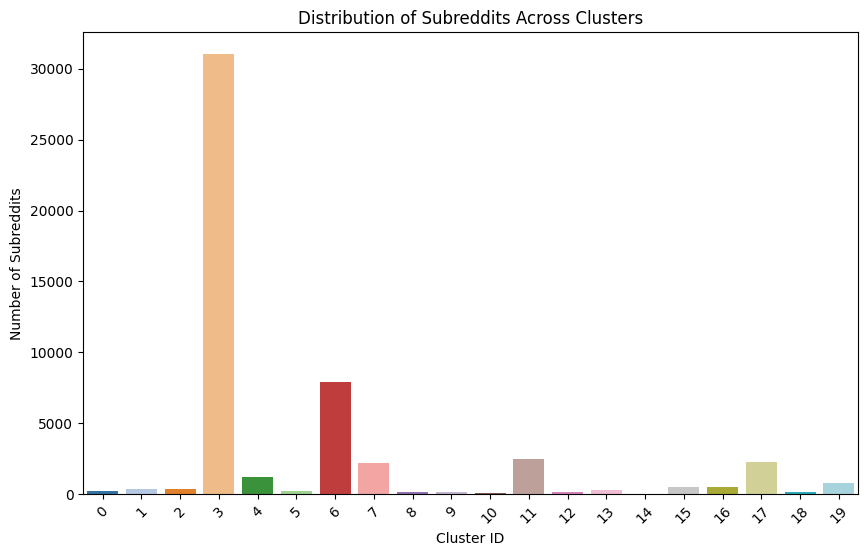

In [3]:
cluster_labels = ClusteringModels.KMeans(df_subreddit_embeddings, k=20)
ClusteringModels.plot_cluster_distribution(cluster_labels)
df_subreddit_embeddings_clustered = pd.concat([df_subreddit_embeddings, cluster_labels], axis=1)

We then use PCA to reduce dimensionality of the embeddings to 3 dimensions and plot the clusters found with K-Means in a 3D scatter plot.


PCA explained variance: 36.56% (3 components)
Individual variance: PC1=16.8%, PC2=10.7%, PC3=9.1%


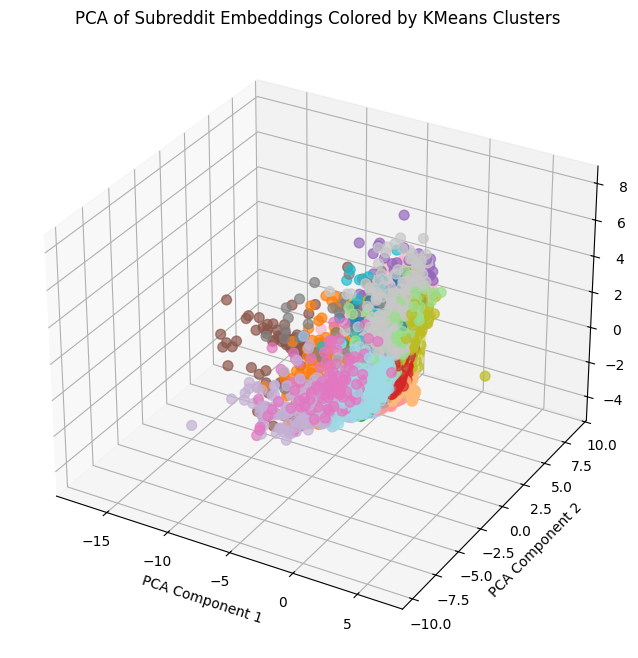

In [4]:
embeddings_3d, pca = ClusteringModels.PCA_reduction(df_subreddit_embeddings, n_components=3)
ClusteringModels.plot_PCA_3D(embeddings_3d, cluster_labels)

#### Spike Detection (Target/Source)

This analysis identifies significant monthly spikes in subreddit hyperlink activity by comparing current behavior against a 6-month rolling average baseline. For each subreddit, we track both incoming links (when other subreddits link to that subreddit, indicating it's being targeted) and outgoing links (when that subreddit links to other subreddits, indicating it's doing the targeting).

A spike is detected when the monthly link count significantly deviates from the rolling average using a Z-score threshold. This reveals:

- **Positive spikes in TARGET (incoming)**: Subreddits receiving unusually high positive mentions, revealing the most "liked" or appreciated communities during specific months
- **Negative spikes in TARGET (incoming)**: Subreddits receiving unusually high negative mentions, revealing the most "hated" or criticized communities
- **Positive spikes in SOURCE (outgoing)**: Subreddits that become unusually active in positively linking to others, revealing the most enthusiastic "likers"
- **Negative spikes in SOURCE (outgoing)**: Subreddits that become unusually active in negatively linking to others, revealing the most prolific "haters"

By establishing a baseline from historical behavior, this method highlights anomalous events, potentially indicating controversial events, brigading, community conflicts, or viral moments.

In [5]:
df_spike_analysis = load_spike_dataframe()
positive_spikes_in, negative_spikes_in = spike_analysis(df_spike_analysis, 'TARGET')
positive_spikes_out, negative_spikes_out = spike_analysis(df_spike_analysis, 'SOURCE')

plot_spike_analysis(negative_spikes_in, positive_spikes_in, negative_spikes_out, positive_spikes_out)

## Seasonal Analysis

We perform an analysis to identify trends of the LIWC categories corresponding to Positive Emotions, Negative Emotions, Affection, Anxiety, Anger and Sadness, present in each hyperlink's properties, over different time scales. First we aggregate by season, then by month, and finally by week, using a 7-day rolling average. For each time scale, we plot the average trends of each category over time, highlighting evident seasonal patterns and fluctuations in emotional expressions.


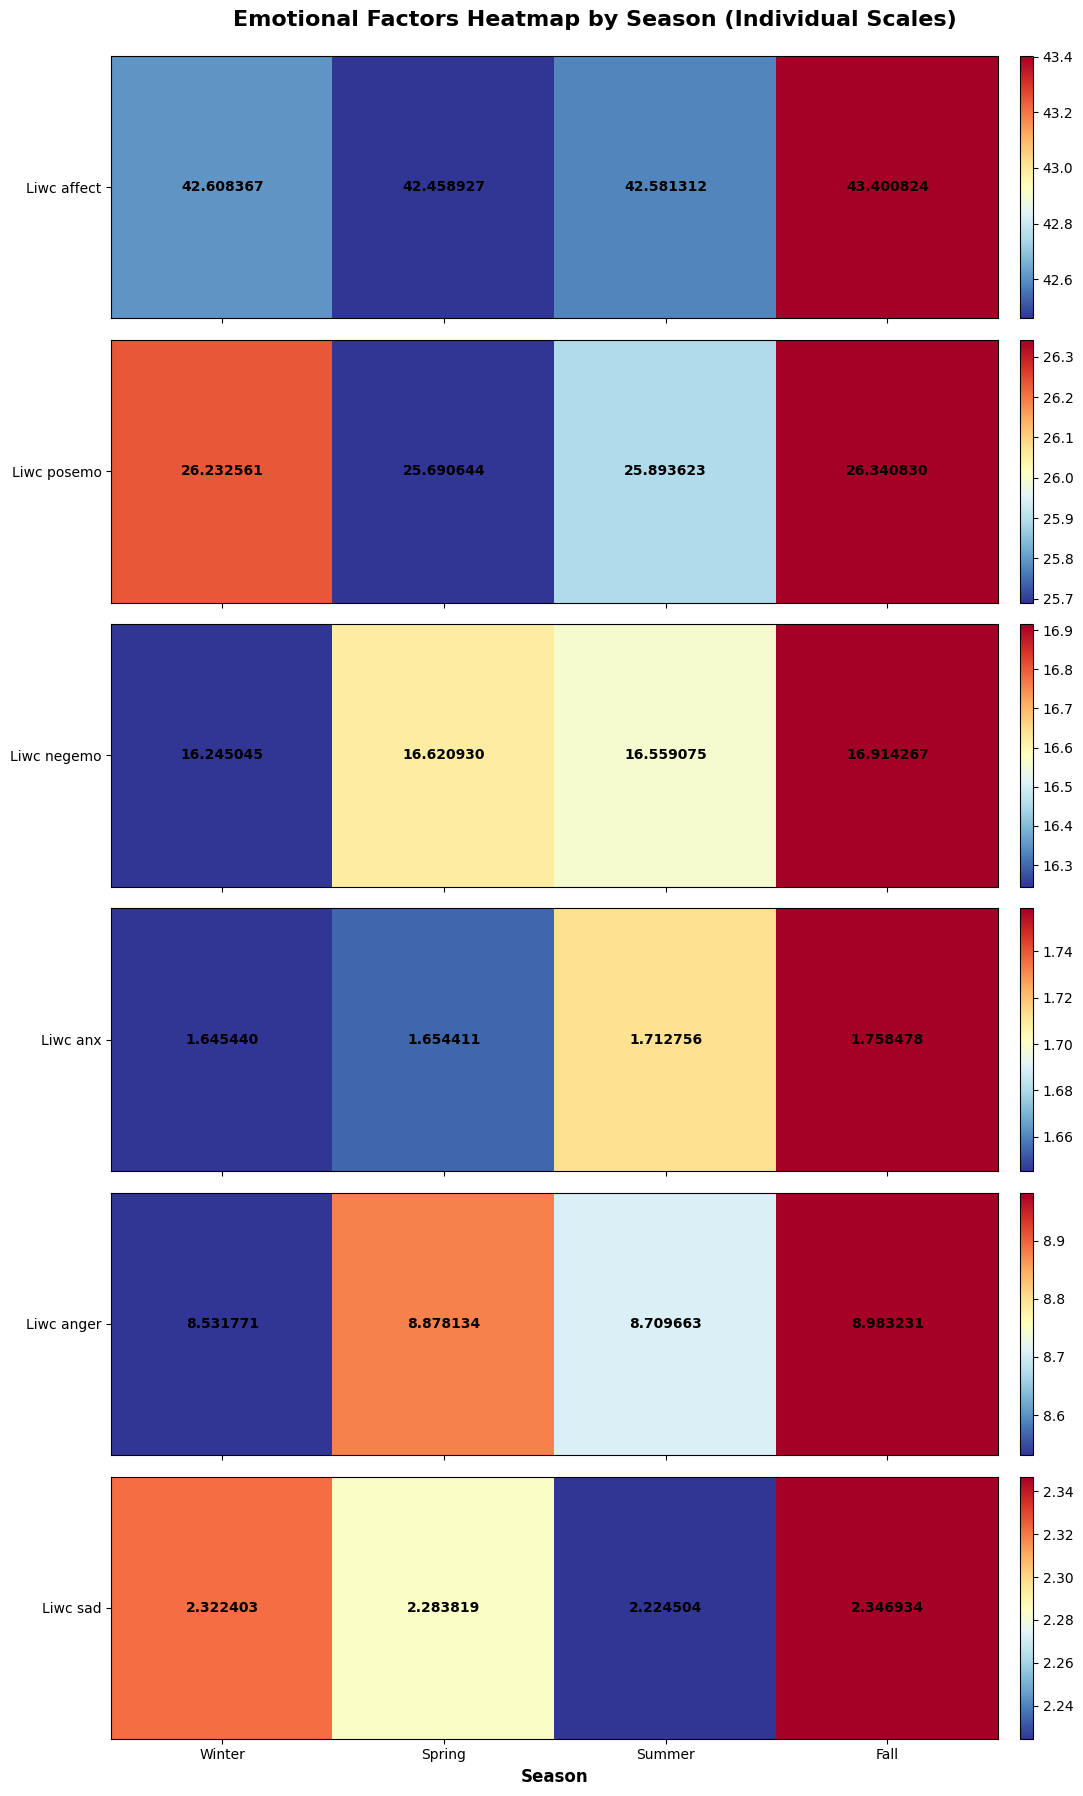

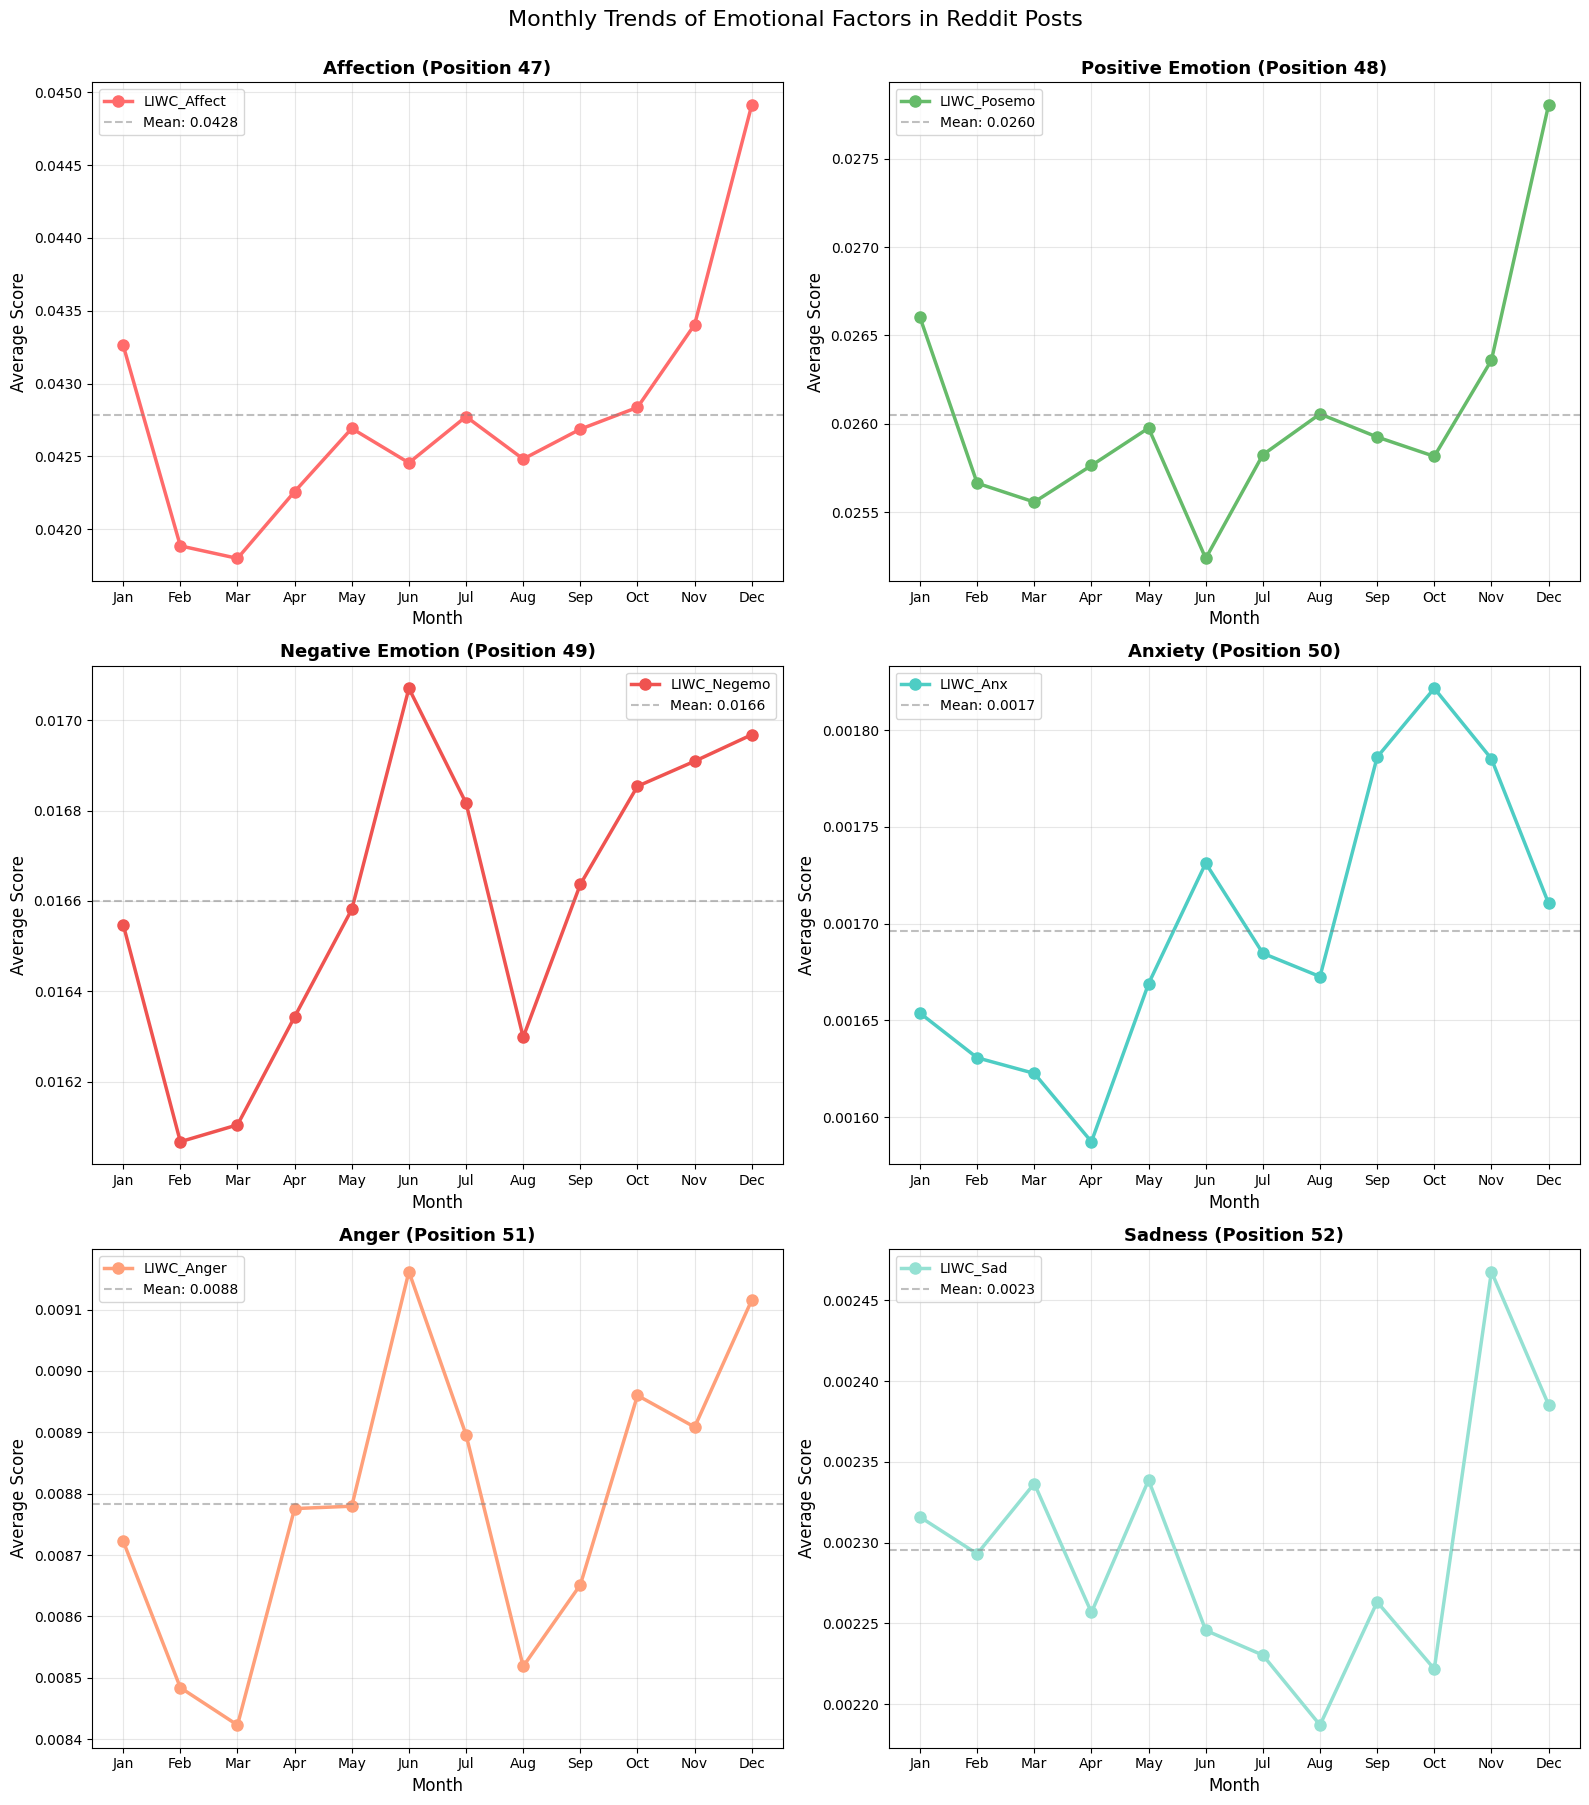

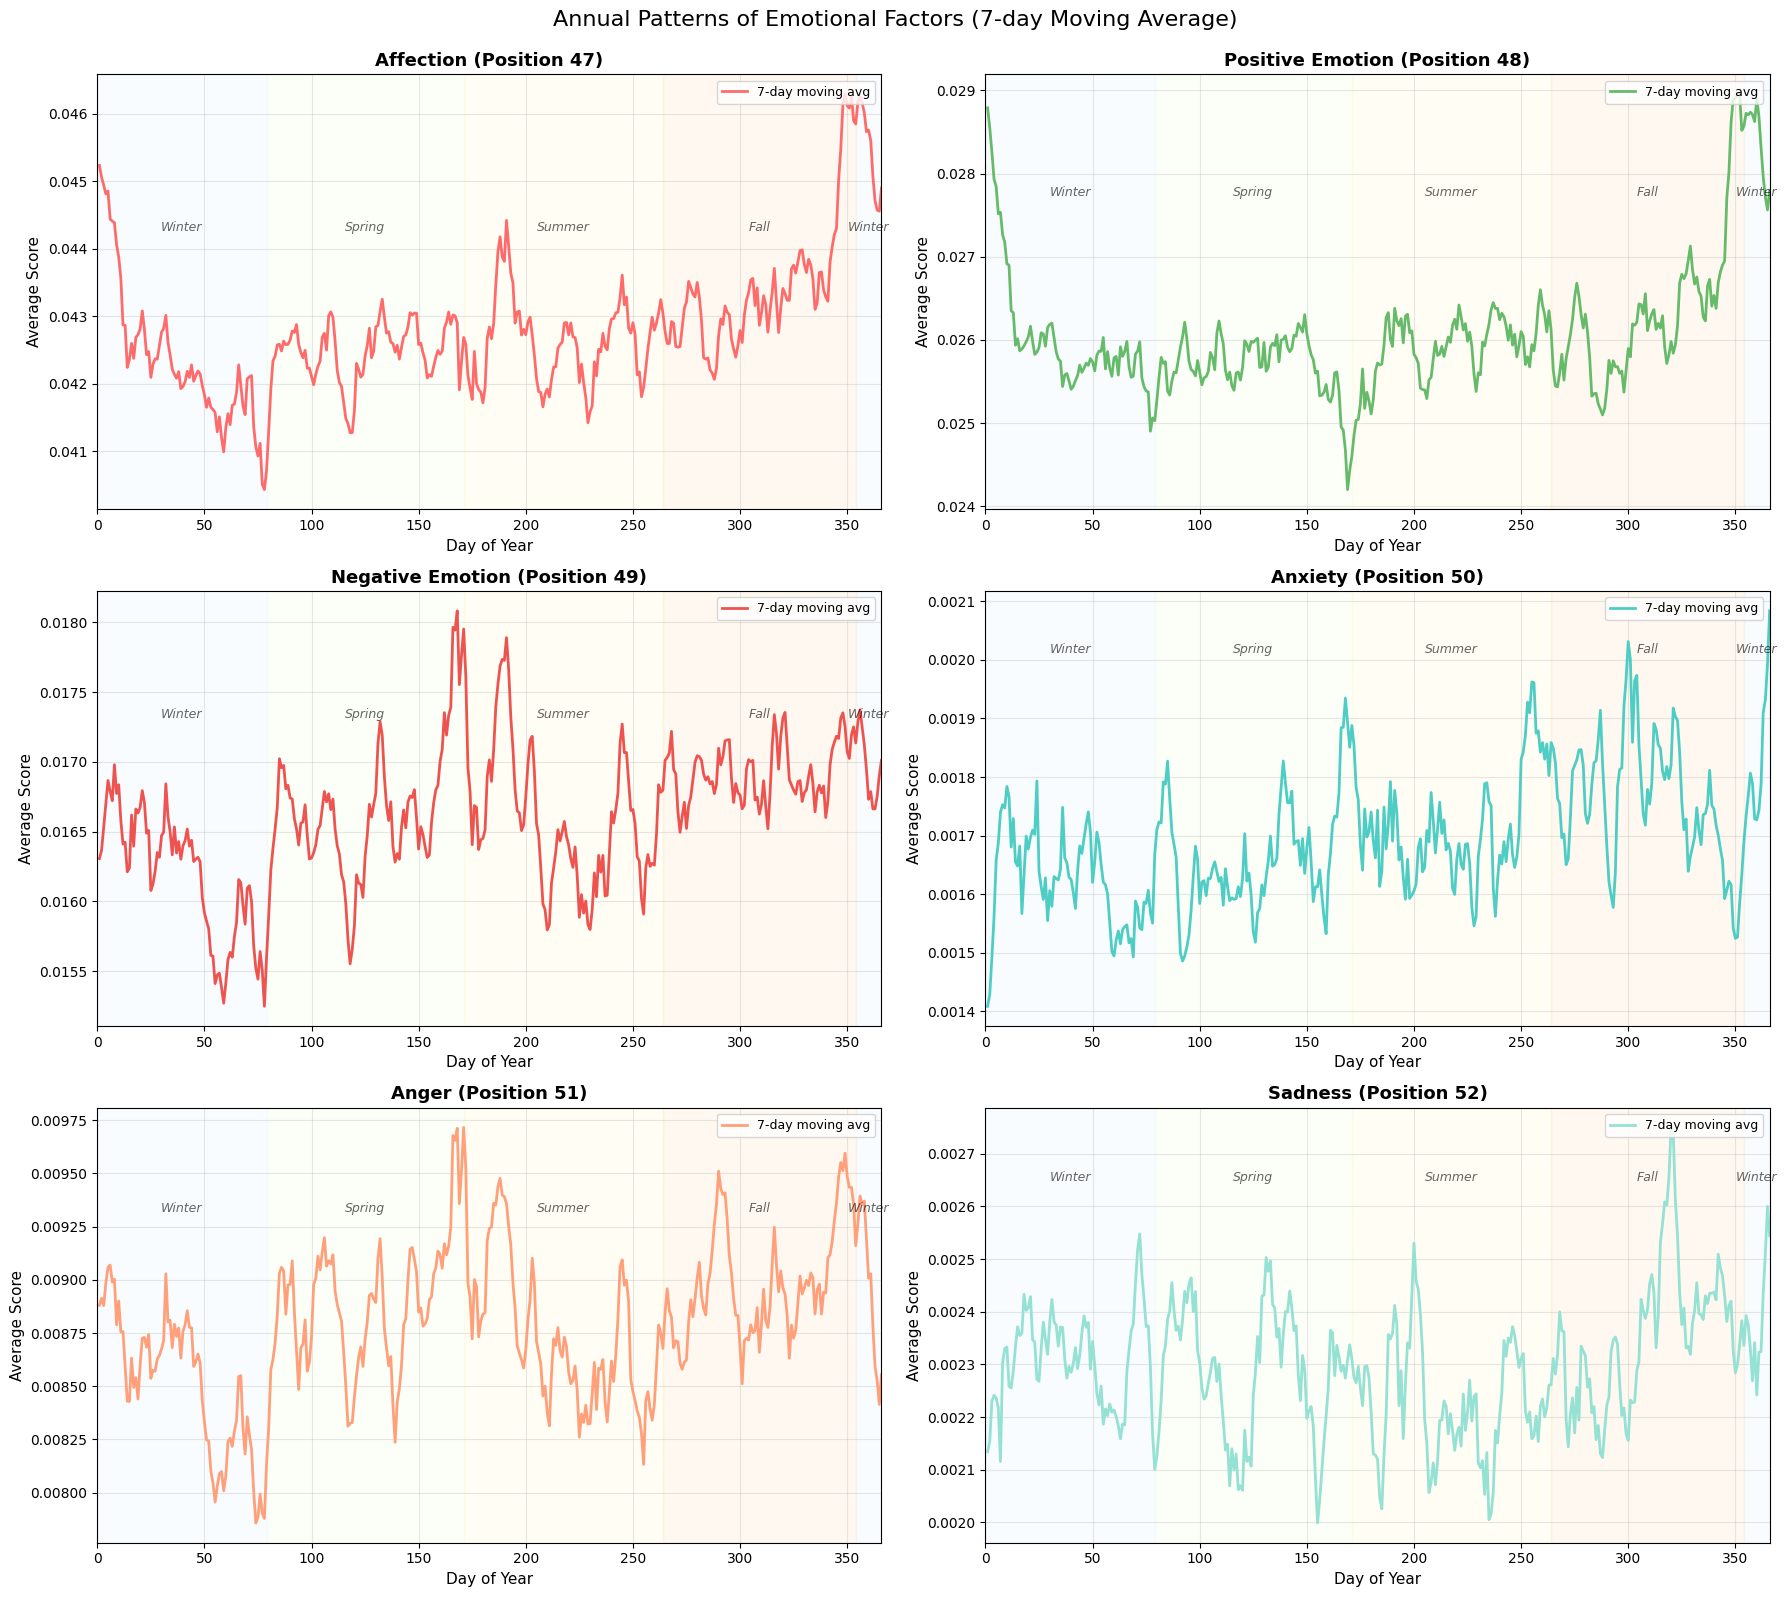

In [6]:
SeasonalEmotionAnalyzer.plot_seasonal_emotions(df_hyperlinks)
SeasonalEmotionAnalyzer.plot_monthly_daily_emotions(df_hyperlinks)
SeasonalEmotionAnalyzer.plot_annual_emotion_patterns(df_hyperlinks)

## Real world events

We try to correlate anomalies (in this case, spikes in the number of hyperlinks, but eventually also leveraging sentiment or emotional factors as done previously) with impactful real world events. As an example, we focus on subreddits similar to r/nba (detected via cosine similarity of embeddings) and notice a significant spike corresponding to one of the most historic games in NBA history: Game 7 of the 2016 NBA Finals between the Cleveland Cavaliers and the Golden State Warriors.

Subreddits similar to ['nba']: {'chicagobulls', 'gonets', 'rockets', 'orlandomagic', 'nba', 'laclippers', 'utahjazz', 'nbaspurs', 'timberwolves', 'lakers', 'warriors', 'clevelandcavs', 'thunder'}
Filtered hyperlinks shape: (4621, 94)


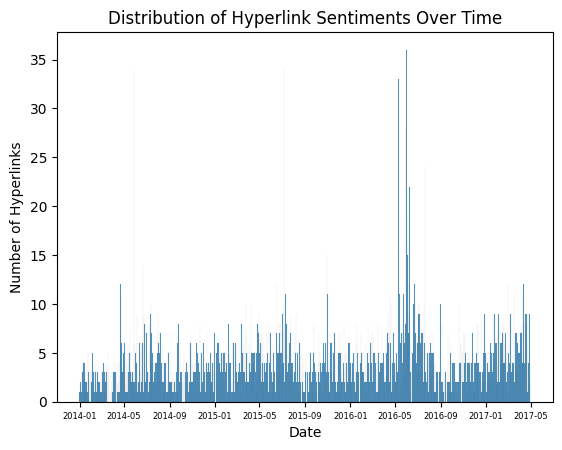

Top 5 dates with highest number of hyperlinks:
TIMESTAMP_DATE
2016-05-31    36
2015-07-06    34
2014-05-27    34
2016-05-10    33
2016-05-30    28
Name: count, dtype: int64


In [7]:
RealWorldEventsAnalyzer.analyze_real_world_events(df_hyperlinks, df_subreddit_embeddings, subreddits_of_interest=['nba'], threshold=0.9)

## Stock Analysis

Next up, we look at the correlation of a sentiment in r/apple related subreddits and it's stocks. <br>
To find related subreddits we used the embeddings of the subreddits performing a sementic search on the dataset. <BR>
We start by visualization of the sentiment regarding Apple using the LIWC feature. <br>
The dataset contain two sentiments analysis : vader and a custom one from the dataset. The study recommend to use the latter one. <br>

In [8]:
from src.utils.stock_market_utils import map_subreddit_to_security, find_similar_subreddits, load_stock_df
from src.plot.stock_market_plots import *
from src.data.loaders import load_merged_hyperlinks, load_subreddit_embeddings
import kagglehub

brand_of_interest = "apple"

brands = find_similar_subreddits(brand_of_interest, df_subreddit_embeddings)
print(f"Subreddits similar to '{brand_of_interest}': {[name for name, _ in brands]}")

path_finance = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")
stock_df = load_stock_df(brand_of_interest, path_finance)
initialize_vars(df_hyperlinks, stock_df, brands, brand_of_interest, df_embeddings=df_subreddit_embeddings, path_finance=path_finance)

Subreddits similar to 'apple': ['apple', 'iphone', 'applewatch', 'appletv', 'ios8', 'ios', 'mac', 'ios9', 'osx', 'ios10', 'ipad', 'iosprogramming', 'applehelp', 'iphone6s', 'iosbeta', 'tmobile', 'applemusic', 'amazonecho', 'alcatelwatch', 'blackberry', 'pebble', 'iphone6', 'chromecast']


/home/andrea/Uni/ADA/ada-2025-project-ambassadorsfordataappreciation/.ada_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



No similar subreddits found for broadcom
No similar subreddits found for asml
No similar subreddits found for micron
Computed aggregate correlations: 86 features across 15 brands


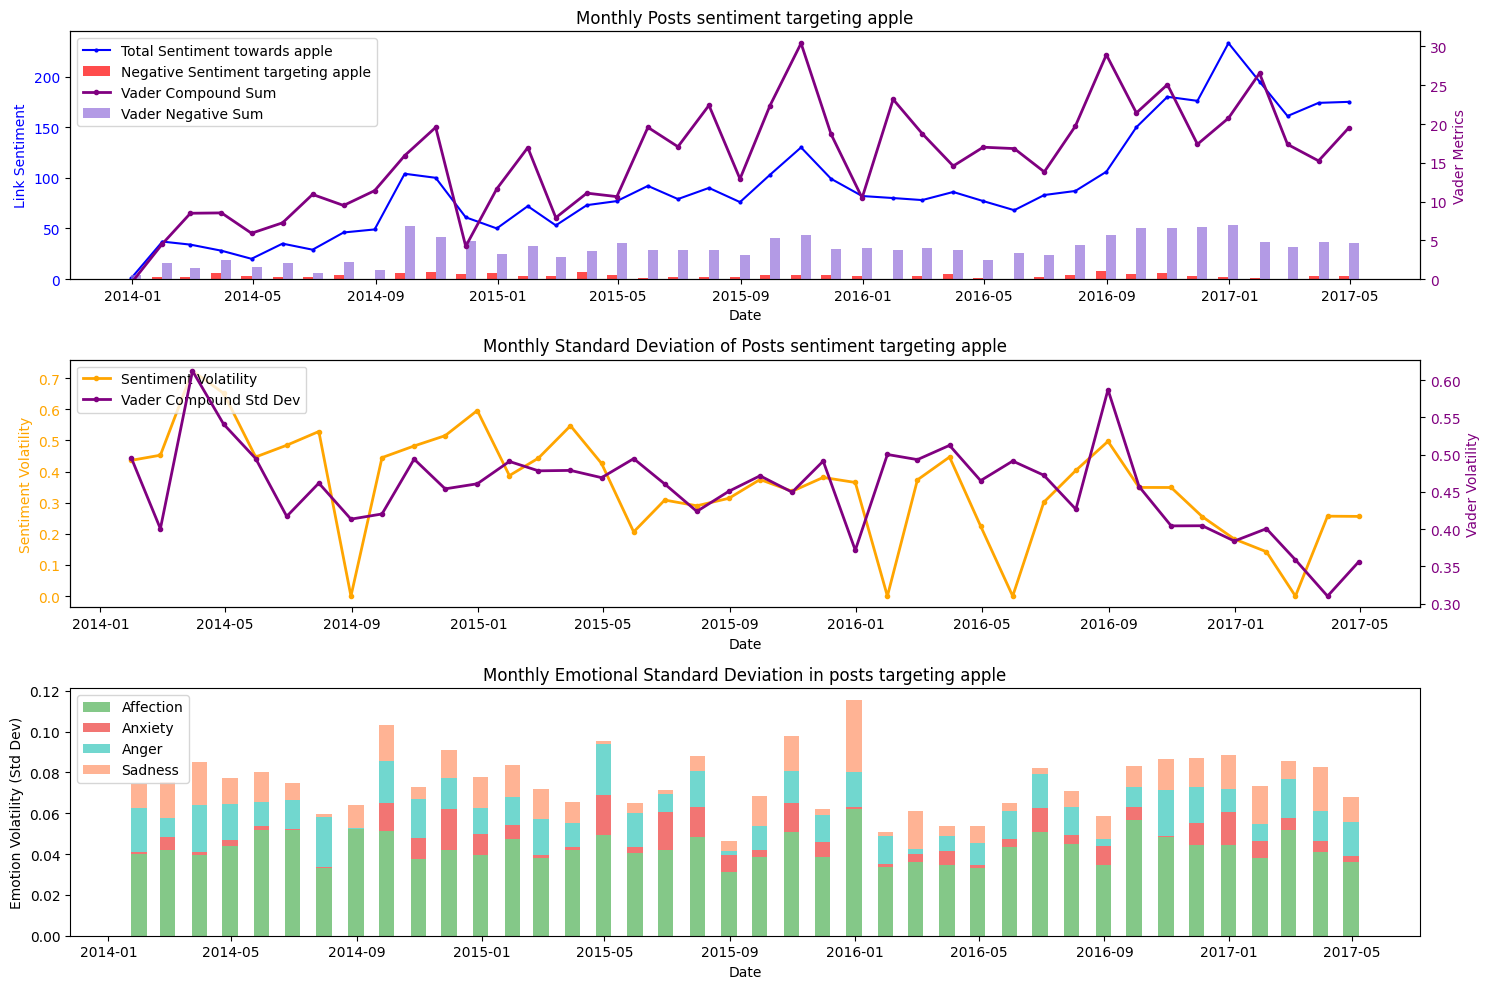

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

plot_monthly_sentiment_brand(axes[0])
plot_monthly_volatility_brand(axes[1])
plot_monthly_emotion_volatility_brand(axes[2])

fig.tight_layout()
plt.show()

Now that we have a basic understanding of our emotions, let's look at stock data and compare it to the sentiment analysis.

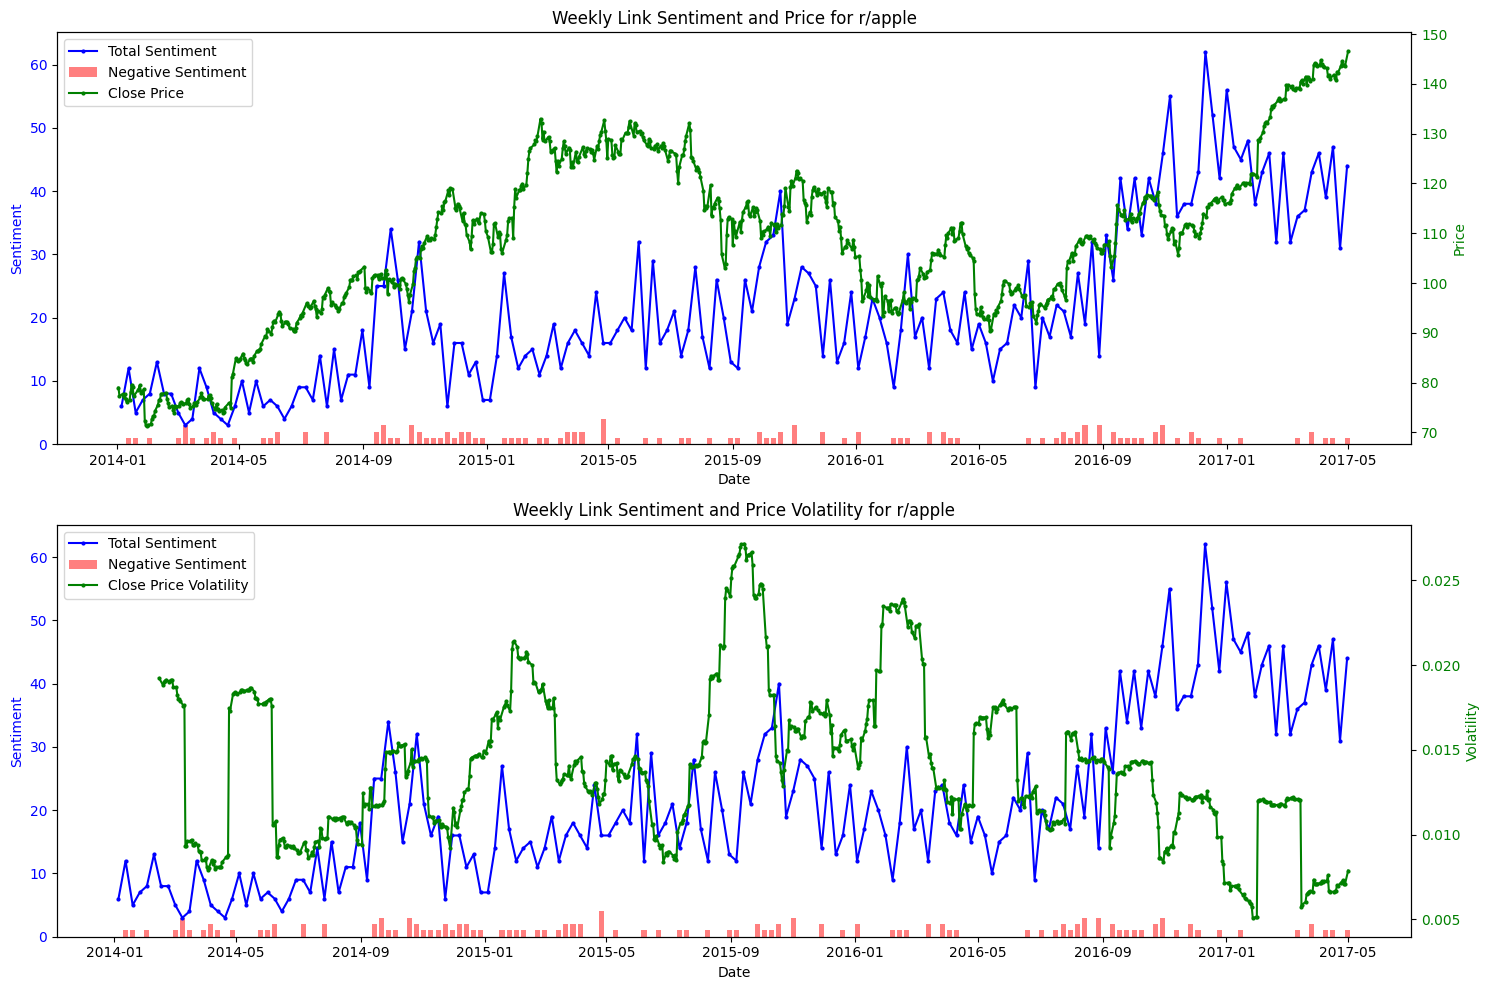

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

plot_weekly_sentiment_vs_stock_price(axes[0])
plot_weekly_sentiment_std_vs_stock_price_std(axes[1])

plt.tight_layout()
plt.show()

Surprisingly, we find a strong correlation in the first graph. This is mostly due to Reddit’s user-base growth, as well as the rise in Apple’s stock price from 2014 to 2017. <br>
We need to look at volatility (std) and its correlation, and to see whether this is a general pattern or Apple-specific. <br>
We refer to “brands” as the set of the 20 most well-known brands. <br><br>
To do so, we analyze each sentiment feature against stock price and volume volatility to identify the most informative signals. We observe notable correlations, which suggests that Reddit user activity is linked to real-world market dynamics

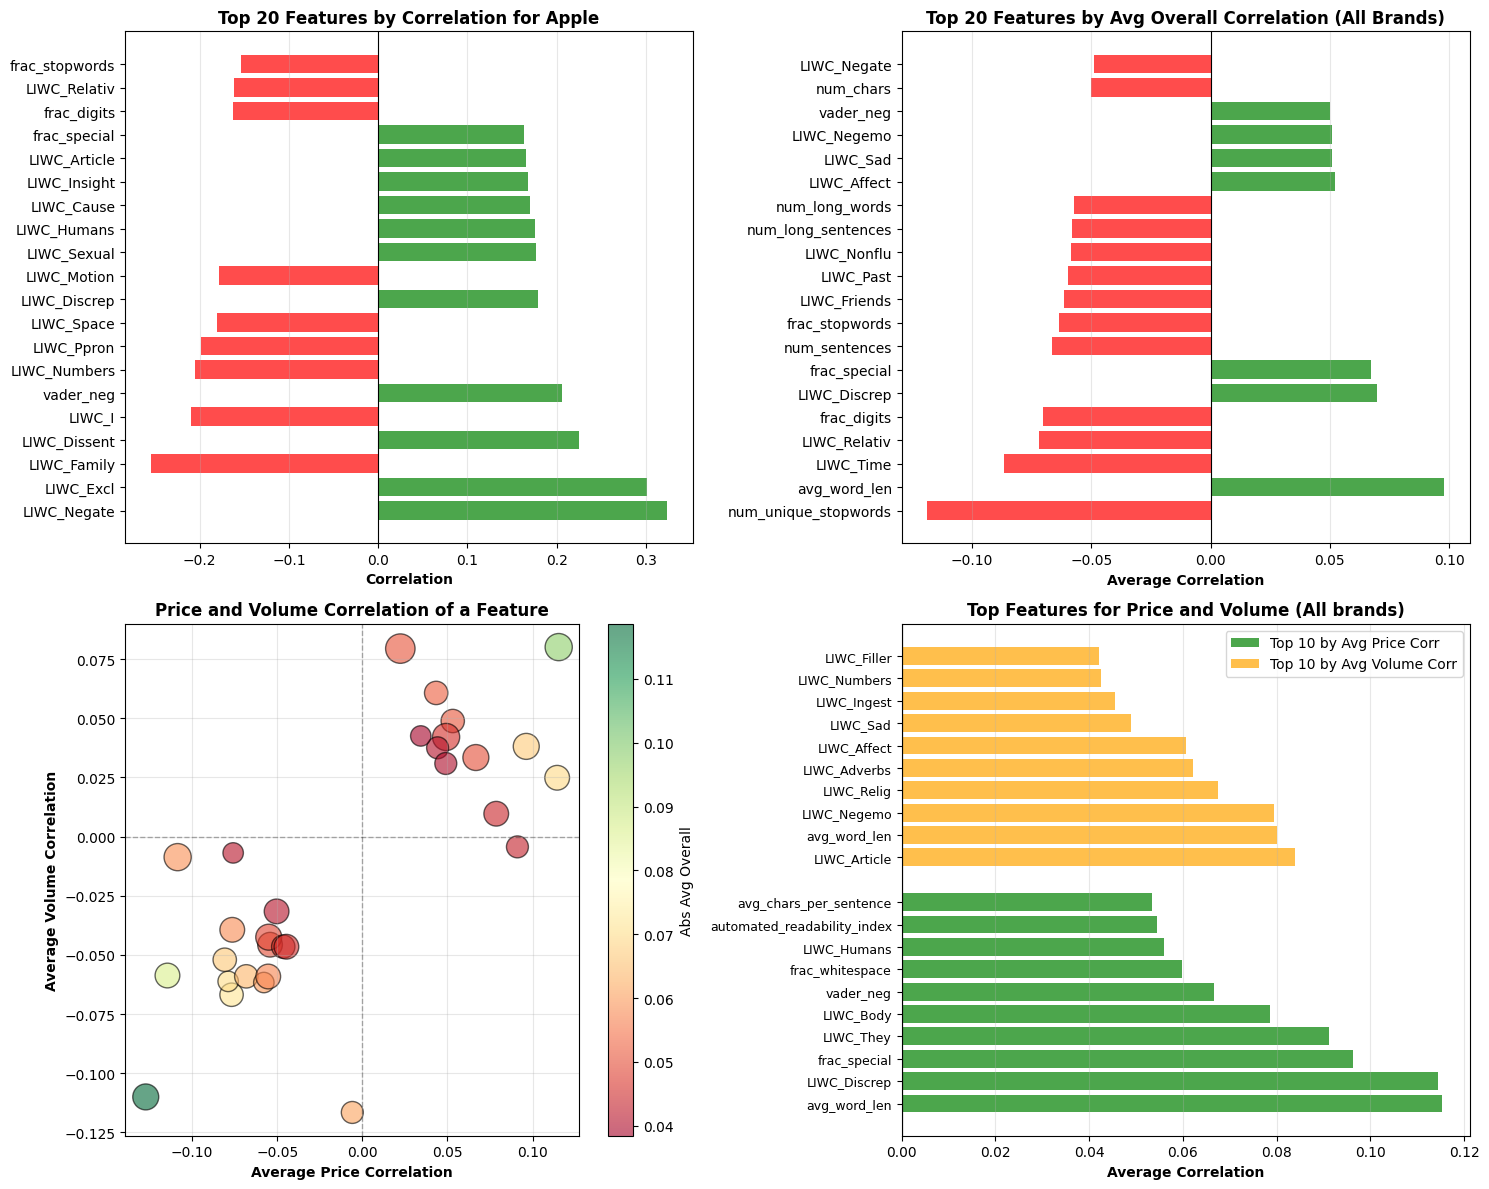

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

plot_features_std_vs_price_std_single_brand(axes[0,0])
plot_features_std_vs_price_std(axes[0,1])

plot_features_std_vs_volume_std(axes[1,0])
plot_features_std_vs_price_volume(axes[1, 1])
plt.tight_layout()
plt.show()